<a href="https://colab.research.google.com/github/Yusunkim4448/DeSAMQ/blob/main/notebooks/IQM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ============================================================
#  Input Quality Module (IQM)
#  - Lightweight CNN classifier to detect Clean vs Noisy images
#  - Used as the first stage in the DeSAM-Q pipeline
#  - This module filters out low-quality scans before segmentation
# ============================================================

In [ ]:
# LLM Disclosure:
# Parts of this code (e.g., PyTorch syntax reminders, integration hints for SAM) were assisted by ChatGPT -5.1
# All design decisions, modifications, debugging, and final implementation were fully authored and verified by the author

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The official SAM implementation is not published on PyPI, so the model
# must be installed directly from the GitHub repository using a git + https
# URL. This ensures the latest, version of SAM is available
!pip install git+https://github.com/facebookresearch/segment-anything.git

# These packages provide image transformation, tensor conversion, visulaization
# and other essential utilites for the SAM and IQM peipeline.
# opencv-python: mask overlay & preprocessing
# pillow       : image loading
# numpy        : numerical operations
# matplotlib   : visualization
# torchvision  : neural network transforms and backbones
!pip install opencv-python pillow numpy matplotlib torchvision

import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

os.makedirs("outputs/masks", exist_ok=True)
os.makedirs("outputs/seg", exist_ok=True)
os.makedirs("outputs/iou", exist_ok=True)


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-377gh5e9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-377gh5e9
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Device: cuda


CNN classifier used to determine whether a medical image is CLEAN or NOISY.


In [ ]:
class IQMClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(32 * 64 * 64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

iqm_model = IQMClassifier().to(device)
# Load pretrained IQM weights
state = torch.load("/content/drive/MyDrive/MLBio/IQM_model.pth", map_location=device)
iqm_model.load_state_dict(state)
iqm_model.eval()

print("IQM model loaded.")


IQM model loaded.


Load an image for the IQM module
Steps:
1. Open image using PIL
2. Convert to grayscale (IQM is trained on CT images)
3. Resize to 256 x 256
4. Convert to Pytorch tensor and add batch dimension

In [ ]:
def load_image_iqm(path):
    img = Image.open(path).convert("L").resize((256, 256))
    tensor = T.ToTensor()(img).unsqueeze(0).to(device)
    return tensor


Load SAM-B (Segment Anything Model, Vit-B encoder)

In [ ]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
# download checkpoint if missing
if not os.path.exists(sam_checkpoint):
    !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
# load sam-b from the official registry
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint).to(device)
# create a predictor wrapper (handles preprocessing + mask prediction)
predictor = SamPredictor(sam)

print("SAM-B loaded.")


SAM-B loaded.


In [ ]:
class IoUPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(256*256, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )

    def forward(self, mask):
        flat = mask.view(mask.size(0), -1)
        return self.mlp(flat)

iou_model = IoUPredictor().to(device)
iou_model.eval()

print("IoU-lite model loaded (dummy).")


IoU-lite model loaded (dummy).


Stage1 pipeline:
- IQM quality filtering
- SAM-B segmentation
- IOU -lite confidence estimation

In [ ]:
def run_stage1_quality_seg_pipeline(image_path, refine_threshold=0.5):

    print(f"\n=== Processing {image_path} ===")

    # -------------------------------------
    # 1) IQM FILTER
    # -------------------------------------
    iqm_in = load_image_iqm(image_path)
    with torch.no_grad():
        logits = iqm_model(iqm_in)
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1).item()

    if pred == 1:
        print("IQM: NOISY → filtered out\n")
        return None

    print("IQM: CLEAN → segmentation allowed")

    # -------------------------------------
    # 2) SAM SEGMENTATION
    # -------------------------------------
    orig = Image.open(image_path).convert("RGB")
    img_cv = cv2.cvtColor(np.array(orig), cv2.COLOR_RGB2BGR)

    predictor.set_image(img_cv)

    h, w = img_cv.shape[:2]
    point_coords = np.array([[w//2, h//2]])
    point_labels = np.array([1])

    masks, _, _ = predictor.predict(
        point_coords=point_coords,
        point_labels=point_labels,
        multimask_output=False,
    )

    mask = masks[0].astype(np.float32)
    mask_resized = cv2.resize(mask, (256, 256))

    # -------------------------------------
    # 3) IoU-lite
    # -------------------------------------
    mask_tensor = torch.tensor(mask_resized).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        iou_pred = iou_model(mask_tensor).item()

    print(f"IoU-lite predicted: {iou_pred:.3f}")

    return {
        "image": orig,
        "mask": mask,
        "iou": iou_pred,
    }


In [ ]:
base_dir = "/content/drive/MyDrive/MLBio/datasets/test_images"
subfolders = ["clean", "noisy"]

images = []
for sub in subfolders:
    folder = f"{base_dir}/{sub}"
    for f in os.listdir(folder):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            images.append(f"{folder}/{f}")

print("Found images:", images)

results = []
for img in images:
    out = run_stage1_quality_seg_pipeline(img)
    if out is not None:
        results.append(out)

print("\n===== DONE =====")


Found images: ['/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_003.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_005.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_008.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_000.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_002.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_004.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_007.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_006.png', '/content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_001.png', '/content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_002.png', '/content/drive/MyDrive/MLBio/datas

Put the original and mask together and make overlaied image

In [ ]:
def overlay_mask_on_image(image_pil, mask, alpha=0.5):
    """
    image_pil: PIL RGB image
    mask: float32, 0~1 mask (H x W)
    alpha: transparency
    """
    img = np.array(image_pil).astype(np.float32) / 255.0
    mask_3d = np.stack([mask, np.zeros_like(mask), np.zeros_like(mask)], axis=-1)

    overlay = img.copy()
    overlay = overlay * (1 - alpha) + mask_3d * alpha

    return np.clip(overlay, 0, 1)


In [ ]:
SAVE_ROOT = "/content/drive/MyDrive/MLBio/outputs"
os.makedirs(SAVE_ROOT, exist_ok=True)
def save_overlay(image, mask, filename):
    overlay = overlay_mask_on_image(image, mask)

    overlay_img = Image.fromarray((overlay * 255).astype(np.uint8))

    save_path = f"{SAVE_ROOT}/{filename}"

    overlay_img.save(save_path)
    print(f"[SAVED] Overlay → {save_path}")


In [ ]:
def run_pipeline_simple(image_path, tau_accept=0.9, tau_feedback=0.5):

    print(f"\n=== Processing {image_path} ===")

    # -----------------------
    # 1) IQM FILTER
    # -----------------------
    iqm_in = load_image_iqm(image_path)
    with torch.no_grad():
        logits = iqm_model(iqm_in)
        pred = torch.argmax(F.softmax(logits, dim=1), dim=1).item()

    if pred == 1:
        print("IQM → NOISY → filtered out")
        return tau_accept   # Nothing else to show

    print("IQM → CLEAN → segmentation allowed")

    # -----------------------
    # 2) SAM SEGMENTATION
    # -----------------------
    orig = Image.open(image_path).convert("RGB")
    img_cv = cv2.cvtColor(np.array(orig), cv2.COLOR_RGB2BGR)

    predictor.set_image(img_cv)

    h, w = img_cv.shape[:2]
    midpoint = np.array([[w//2, h//2]])
    label = np.array([1])

    masks, _, _ = predictor.predict(
        point_coords=midpoint,
        point_labels=label,
        multimask_output=False
    )

    mask = masks[0].astype(np.float32)
    mask_resized = cv2.resize(mask, (256, 256))

    # -----------------------
    # 3) IoU-lite
    # -----------------------
    mask_tensor = torch.tensor(mask_resized).unsqueeze(0).unsqueeze(0).float().to(device)

    with torch.no_grad():
        iou_pred = iou_model(mask_tensor).item()

    print(f"IoU-lite predicted: {iou_pred:.3f}")

    # -----------------------
    # 4) HUMAN FEEDBACK BEFORE IMAGE
    # -----------------------
    if iou_pred >= tau_accept:
        decision = "ACCEPT"
        print("Decision:", decision)

    elif iou_pred >= tau_feedback:
        decision = input("Model is unsure. Accept segmentation? (y/n): ").strip().lower()
        decision = "ACCEPT" if decision == "y" else "REJECTED"

    else:
        decision = input("Low confidence. Accept anyway? (y/n): ").strip().lower()
        decision = "ACCEPT" if decision == "y" else "REJECTED"

    # -----------------------
    # 5) NOW SHOW IMAGES
    # -----------------------
    overlay = overlay_mask_on_image(orig, mask)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.imshow(orig); plt.axis("off")
    plt.subplot(1,3,2); plt.title("Mask"); plt.imshow(mask, cmap='hot'); plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay"); plt.imshow(overlay); plt.axis("off")
    plt.show()

    save_name = os.path.basename(image_path).replace(".png", "_overlay.png")
    save_overlay(orig, mask, save_name)

    # -----------------------
    # 6) ADAPTIVE THRESHOLD UPDATE
    # -----------------------
    if decision == "ACCEPT":
        tau_accept = max(0.5, tau_accept - 0.1)
        print(f"UPDATED τ = {tau_accept:.3f}")
    else:
        print("Segmentation rejected by user.")

    return tau_accept


In [ ]:
def run_all(root_dir):
    images = []
    for sub in ["clean", "noisy"]:
        folder = os.path.join(root_dir, sub)
        for f in os.listdir(folder):
            if f.lower().endswith((".png", ".jpg", ".jpeg")):
                images.append(os.path.join(folder, f))

    print("Found images:", len(images))

    tau = 0.9  #initial threshold

    for img in images:
        tau = run_pipeline_simple(img, tau_accept=tau)

    print("\n===== DONE =====")


This command is final command

It will provide

1.   The input quality check: Filter out the noisy images
2.   IoU score
3. If the model is not sure then it provide the question.
4. Show the original + masked+ overlaied images



Found images: 18

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_003.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.502
Model is unsure. Accept segmentation? (y/n): y


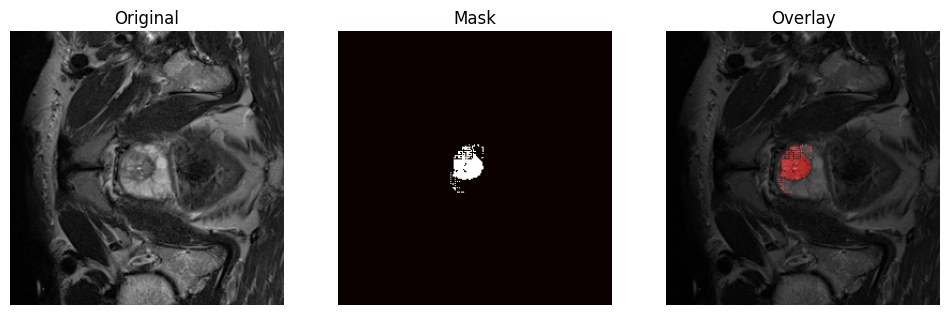

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_003_overlay.png
UPDATED τ = 0.800

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_005.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.515
Model is unsure. Accept segmentation? (y/n): y


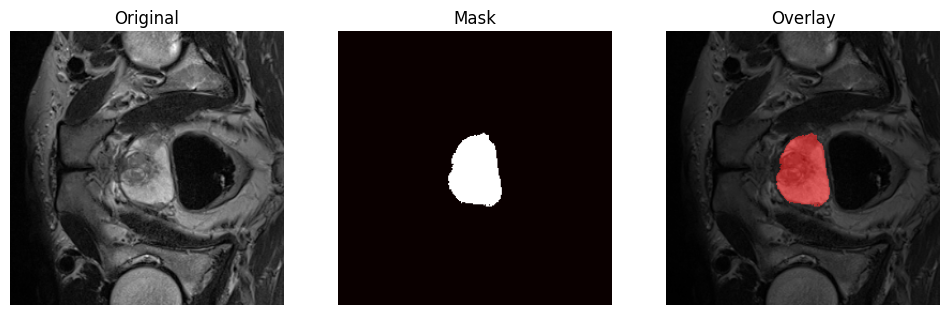

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_005_overlay.png
UPDATED τ = 0.700

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_008.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.524
Model is unsure. Accept segmentation? (y/n): y


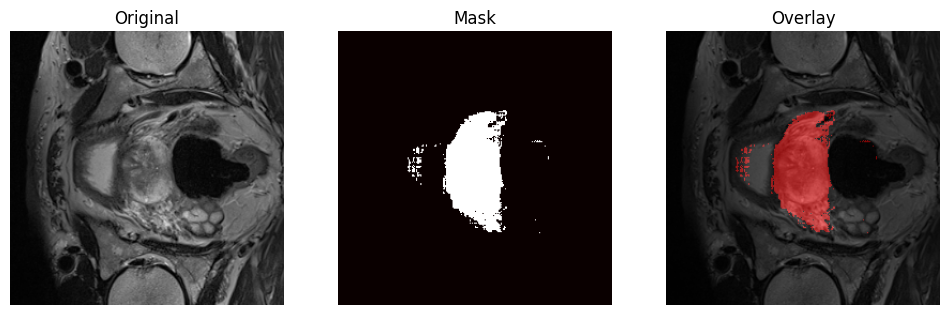

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_008_overlay.png
UPDATED τ = 0.600

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_000.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.505
Model is unsure. Accept segmentation? (y/n): y


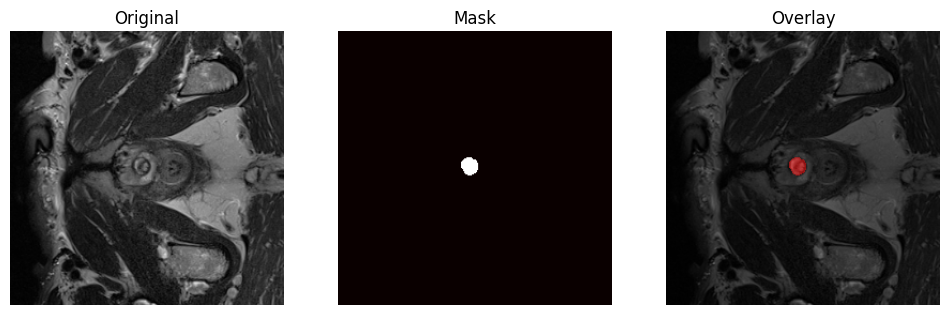

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_000_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_002.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.505
Decision: ACCEPT


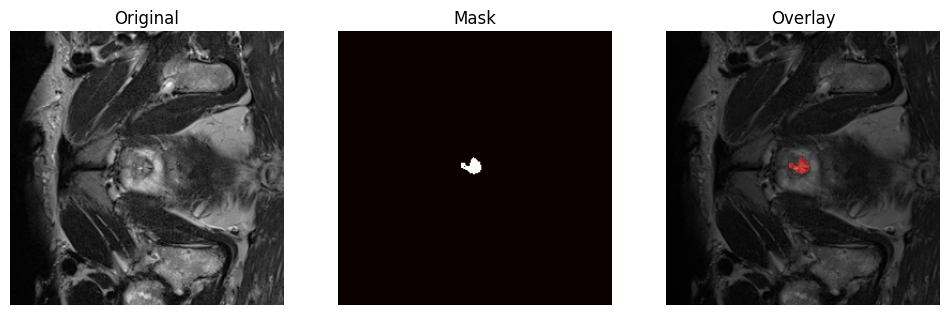

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_002_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_004.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.501
Decision: ACCEPT


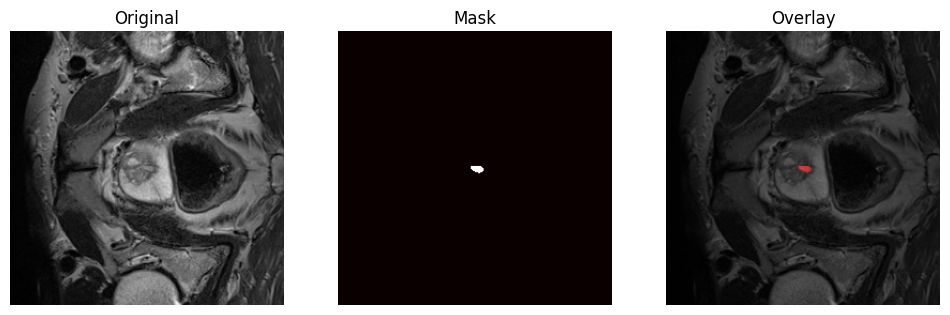

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_004_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_007.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.506
Decision: ACCEPT


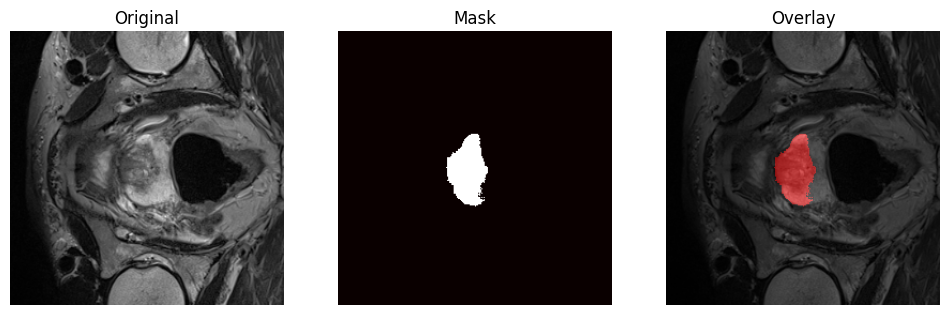

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_007_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_006.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.512
Decision: ACCEPT


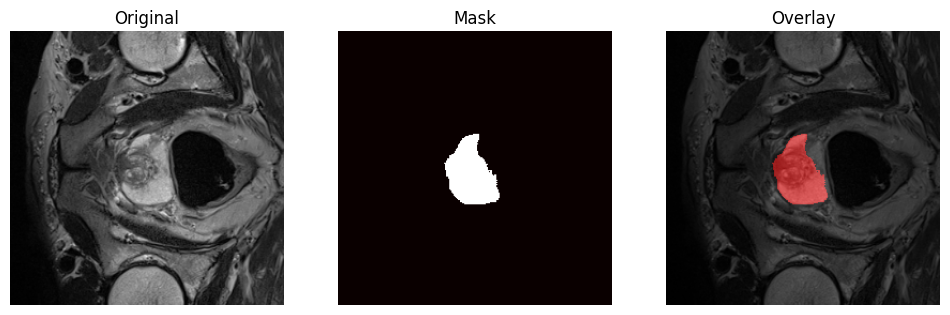

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_006_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/clean/Prostate_009_0000.nii_slice_001.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.506
Decision: ACCEPT


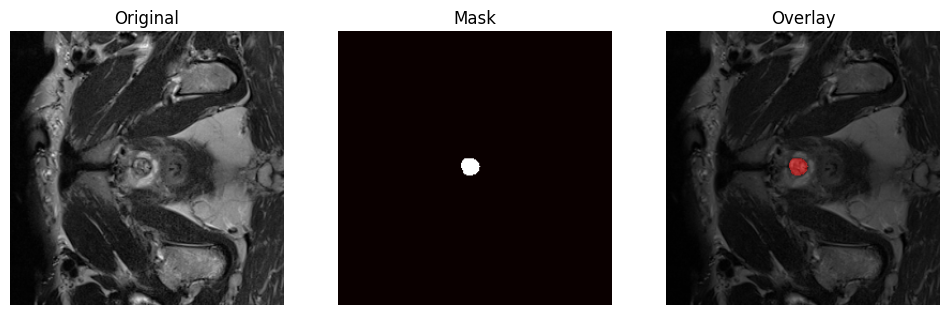

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_001_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_002.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.503
Decision: ACCEPT


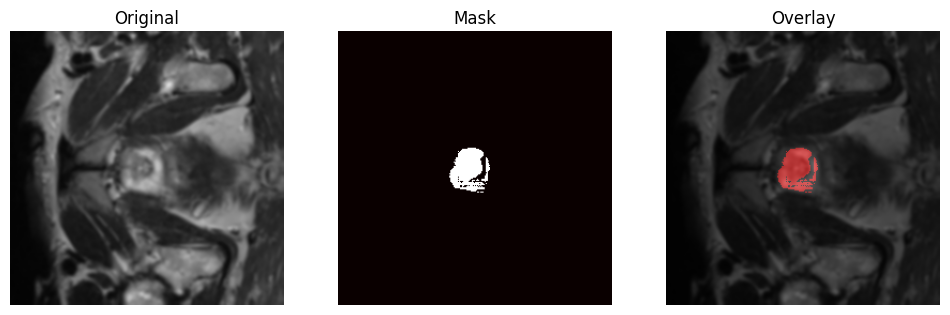

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_002_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_000.png ===
IQM → NOISY → filtered out

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_003.png ===
IQM → NOISY → filtered out

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_001.png ===
IQM → NOISY → filtered out

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_006.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.510
Decision: ACCEPT


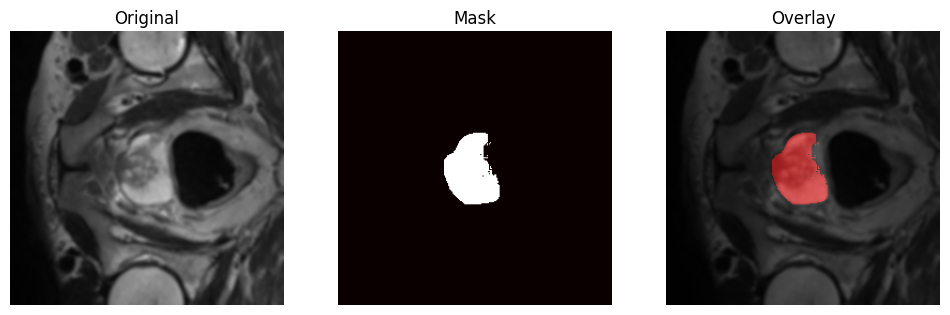

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_006_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_008.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.509
Decision: ACCEPT


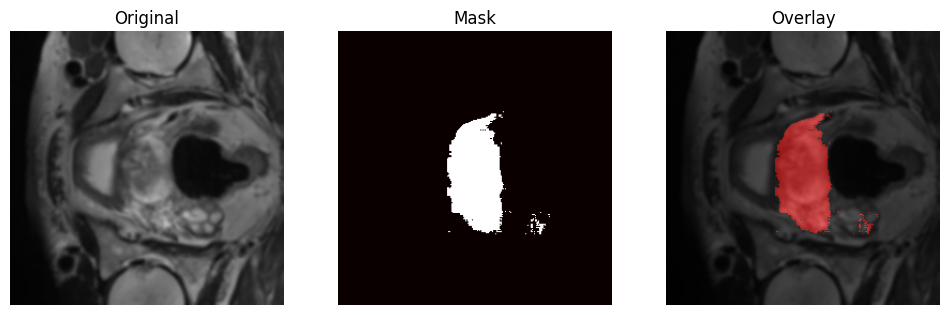

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_008_overlay.png
UPDATED τ = 0.500

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_005.png ===
IQM → NOISY → filtered out

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_004.png ===
IQM → NOISY → filtered out

=== Processing /content/drive/MyDrive/MLBio/datasets/test_images/noisy/Prostate_009_0000.nii_slice_007.png ===
IQM → CLEAN → segmentation allowed
IoU-lite predicted: 0.508
Decision: ACCEPT


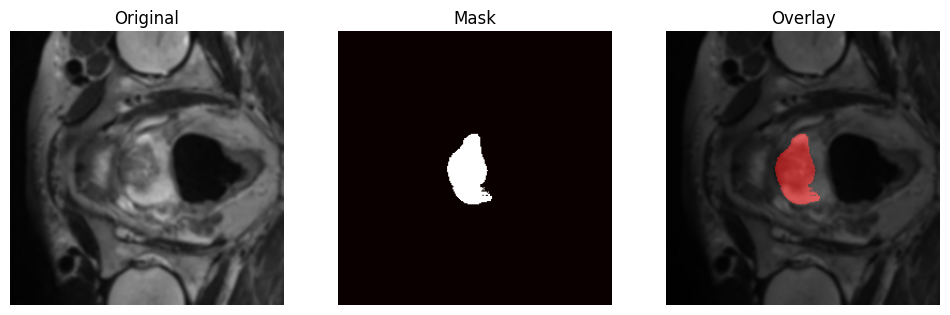

[SAVED] Overlay → /content/drive/MyDrive/MLBio/outputs/Prostate_009_0000.nii_slice_007_overlay.png
UPDATED τ = 0.500

===== DONE =====


In [ ]:
run_all("/content/drive/MyDrive/MLBio/datasets/test_images")
# Due to how Google Colab handles input() calls, and display operations (matplotlib image output)
# cannot be rendered before user input is completed.
# The input() function is blocking, meaning the execution pauses entirely until the user responds.
# As a result, the image cannot appear before the y/n question.
# To avoid this this limitation, I tried ipywidgets callbacks. But due to Colab's event loop limitation,
# The call back functions never executed, making it impossible to continue the segmentation pipeline.
# This problem can be solved if it is developed further as UI.